In [1]:
import collections
from itertools import combinations, chain


# Enumerate subsets with subsets first
def enumerate_subsets(S):
    sS = sorted(S)
    "powerset([1,2,3]) → (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    return chain.from_iterable(combinations(sS, r) for r in range(1,len(sS)+1))

class JoinHypergraph:
    def __init__(self):
        self.nodes = []

        self.edges = []

        self.simple_neighbourhood_by_node = collections.defaultdict(set)
        self.complex_edges_by_node = collections.defaultdict(list)

    def add_node(self, node):
        if node not in self.nodes:
            self.nodes.append(node)

    def add_edge(self, left, right):
        self.edges.append((left, right))
        self.edges.append((right, left))

        if len(left) == len(right) == 1:
            self.simple_neighbourhood_by_node[frozenset(left)] |= right
            self.simple_neighbourhood_by_node[frozenset(right)] |= left
            return

        for node in left:
            self.complex_edges_by_node[node].append((left, right))
        for node in right:
            self.complex_edges_by_node[node].append((right, left))


    def __repr__(self):
        s = f'nodes: {set(self.nodes)}\n'

        s += 'unique edges:\n'
        for edge in self.edges[::2]:
            s += f'{edge}\n'

        return s

    def is_edge_exists_between_sets(self, s1, s2):
        for edge in self.edges:
            if edge[0].issubset(s1) and edge[1].issubset(s2):
                return True
        return False


class JoinExpression:
    def __init__(self):
        self.type = str()  # table or join

        self.left = None
        self.right = None

        self.subtree_nodes = set()
        self.condition_used_tables = set()  # used tables in join condition

    def __repr__(self):
        if self.type != 'TABLE':
            left = self.left

            if left.type != 'TABLE':
                left = f'({repr(left)})'
            else:
                left = str(list(left.subtree_nodes)[0])

            right = self.right

            if right.type != 'TABLE':
                right = f'({repr(right)})'
            else:
                right = str(list(right.subtree_nodes)[0])

            condition_used = ', '.join(list(self.condition_used_tables))
            return f'{left} {self.type} JOIN {right} on ({condition_used})'
        else:
            return f'{self.subtree_nodes}'


class ConflictRule:
    def __init__(self, activation_nodes, required_nodes):
        self.activation_nodes = activation_nodes
        self.required_nodes = required_nodes

    activation_nodes = set()
    required_nodes = set()


ASSOC_TABLE = {
    'INNER': {'INNER', 'LEFT OUTER'},
    'LEFT OUTER': {'LEFT OUTER'},
    'FULL OUTER': {'LEFT OUTER', 'FULL OUTER'},
}

LASSCOM_TABLE = {
    'INNER': {'INNER', 'LEFT OUTER'},
    'LEFT OUTER': {'INNER', 'LEFT OUTER', 'FULL OUTER'},
    'FULL OUTER': {'LEFT OUTER', 'FULL OUTER'},
}

RASSCOM_TABLE = {
    'INNER': {'INNER'},
    'LEFT OUTER': {},
    'FULL OUTER': {'FULL OUTER'},
}


def operators_are_assoc(lhs, rhs):
    return rhs.type in ASSOC_TABLE[lhs.type]


def operators_are_left_asscom(lhs, rhs):
    return rhs.type in LASSCOM_TABLE[lhs.type]


def operators_are_right_asscom(lhs, rhs):
    return rhs.type in RASSCOM_TABLE[lhs.type]


class ConflictRulesCollector:
    def __init__(self, root):
        self.root = root
        self.conflict_rules = []

    def visit_expr_tree(self, child, visitor):
        if child.type == 'TABLE':
            return

        self.visit_expr_tree(child.left, visitor)
        self.visit_expr_tree(child.right, visitor)

        visitor(child)

    def collect_left_conflict(self, child):
        if not operators_are_assoc(child, self.root):
            self.conflict_rules.append(
                ConflictRule(
                    child.right.subtree_nodes,
                    child.left.subtree_nodes
                )
            )

        if not operators_are_left_asscom(child, self.root):
            self.conflict_rules.append(
                ConflictRule(
                    child.left.subtree_nodes,
                    child.right.subtree_nodes
                )
            )

    def collect_right_conflict(self, child):
        if not operators_are_assoc(self.root, child):
            self.conflict_rules.append(
                ConflictRule(
                    child.left.subtree_nodes,
                    child.right.subtree_nodes
                )
            )

        if not operators_are_right_asscom(self.root, child):
            self.conflict_rules.append(
                ConflictRule(
                    child.right.subtree_nodes,
                    child.left.subtree_nodes
                )
            )

    def collect_conflicts(self):
        self.visit_expr_tree(self.root.left, self.collect_left_conflict)
        self.visit_expr_tree(self.root.right, self.collect_right_conflict)
        return self.conflict_rules


def convert_cr_into_tes(ses, conflict_rules):
    tes = ses

    while True:
        prev_tes = tes

        for conflict_rule in conflict_rules:
            if len(conflict_rule.activation_nodes & tes) != 0:
                tes |= conflict_rule.required_nodes

        for conflict_rule in conflict_rules:
            if conflict_rule.required_nodes.issubset(tes):
                del conflict_rule

        if tes == prev_tes or len(conflict_rules) == 0:
            return tes


def find_hyperedge(expr):
    cr_collector = ConflictRulesCollector(expr)
    conflict_rules = cr_collector.collect_conflicts()

    tes = convert_cr_into_tes(ses=expr.condition_used_tables, conflict_rules=conflict_rules)

    left = tes & expr.left.subtree_nodes
    right = tes & expr.right.subtree_nodes
    return left, right


def make_join_hypergraph(graph, expr):
    if expr.type == 'TABLE':
        graph.add_node(list(expr.subtree_nodes)[0])
        return

    make_join_hypergraph(graph, expr.left)
    make_join_hypergraph(graph, expr.right)

    expr.subtree_nodes = expr.left.subtree_nodes | expr.right.subtree_nodes

    left, right = find_hyperedge(expr)

    graph.add_edge(left, right)

def INNER_JOIN(lhs, rhs, on=None):
    return JOIN(lhs, rhs, used_tables=on, type='INNER')

IJ = INNER_JOIN

def LEFT_OUTER_JOIN(lhs, rhs, on=None):
    return JOIN(lhs, rhs, used_tables=on, type='LEFT OUTER')

LJ = LEFT_OUTER_JOIN

def FULL_OUTER_JOIN(lhs, rhs, on=None):
    return JOIN(lhs, rhs, used_tables=on, type='FULL OUTER')

OJ = FULL_OUTER_JOIN

def JOIN(lhs, rhs, type, used_tables):
    if used_tables is None:
        used_tables = {lhs, rhs}
    else:
        used_tables = set(used_tables.split(', '))

    expr = JoinExpression()
    expr.type = type

    left_expr = lhs

    if isinstance(left_expr, str):
        left_expr = JoinExpression()
        left_expr.type = 'TABLE'
        left_expr.subtree_nodes = set(lhs)

    right_expr = rhs

    if isinstance(right_expr, str):
        right_expr = JoinExpression()
        right_expr.type = 'TABLE'
        right_expr.subtree_nodes = set(rhs)

    expr.left = left_expr
    expr.right = right_expr
    expr.condition_used_tables = used_tables

    return expr

def get_graph(join_expr):
    graph = JoinHypergraph()
    make_join_hypergraph(graph, join_expr)
    return graph

def print_join_hypergraph(join_expr):
    print(join_expr)
    print(get_graph(join_expr))

In [2]:
# playground for hypergraph building

print_join_hypergraph(
    INNER_JOIN(INNER_JOIN('A', 'B'), INNER_JOIN('C', 'D'), on='A, C')
)


(A INNER JOIN B on (A, B)) INNER JOIN (C INNER JOIN D on (D, C)) on (A, C)
nodes: {'D', 'A', 'C', 'B'}
unique edges:
({'A'}, {'B'})
({'C'}, {'D'})
({'A'}, {'C'})



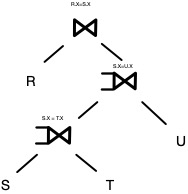

In [3]:
print_join_hypergraph(
    INNER_JOIN('R', LEFT_OUTER_JOIN(LEFT_OUTER_JOIN('S', 'T'), 'U', on='S, U'), on='R, S')
)

R INNER JOIN ((S LEFT OUTER JOIN T on (S, T)) LEFT OUTER JOIN U on (S, U)) on (S, R)
nodes: {'S', 'T', 'U', 'R'}
unique edges:
({'S'}, {'T'})
({'S'}, {'U'})
({'R'}, {'S'})



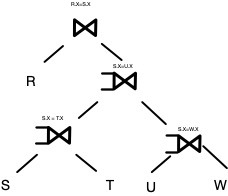

In [4]:
print_join_hypergraph(
    INNER_JOIN('R', 
                LEFT_OUTER_JOIN(
                    LEFT_OUTER_JOIN('S', 'T'),
                    LEFT_OUTER_JOIN('U','W'), on='S, U'),
               on='R, S')
)

R INNER JOIN ((S LEFT OUTER JOIN T on (S, T)) LEFT OUTER JOIN (U LEFT OUTER JOIN W on (W, U)) on (S, U)) on (S, R)
nodes: {'T', 'R', 'W', 'S', 'U'}
unique edges:
({'S'}, {'T'})
({'U'}, {'W'})
({'S'}, {'U'})
({'R'}, {'S'})



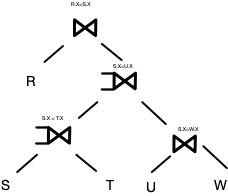

In [5]:
print_join_hypergraph(
    INNER_JOIN('R', 
                LEFT_OUTER_JOIN(
                    LEFT_OUTER_JOIN('S', 'T'),
                    INNER_JOIN('U','W'), on='S, U'),
               on='R, S')
)

R INNER JOIN ((S LEFT OUTER JOIN T on (S, T)) LEFT OUTER JOIN (U INNER JOIN W on (W, U)) on (S, U)) on (S, R)
nodes: {'T', 'R', 'W', 'S', 'U'}
unique edges:
({'S'}, {'T'})
({'U'}, {'W'})
({'S'}, {'W', 'U'})
({'R'}, {'S'})



In [31]:
class DPHyp:
    def __init__(self, graph: JoinHypergraph):
        self.dp = dict()
        self.graph = graph

        # debug
        self.check_table = dict()
        self.counter = 0

    def make_bi(self, v):
        return self.make_b(self.graph.nodes, v)

    def make_b(self, N, v):
        bi = set()
        for node in N:
            if node <= v:
                bi |= {node}
        return bi

    def neighs(self, s, x):
        neighs = set()

        for node in s:
            neighs |= self.graph.simple_neighbourhood_by_node[frozenset([node])]

            for edge in self.graph.complex_edges_by_node[node]:
                left, right = edge

                if left.issubset(s) and \
                    len(right & x) == 0 and  \
                    len(right & s) == 0 and \
                    len(right & neighs) == 0:
                    neighs.add(min(right))

        neighs.difference_update(x)
        return neighs

    def solve(self):
        for node in self.graph.nodes:
            self.dp[frozenset([node])] = True

        for node in sorted(self.graph.nodes, reverse=True):
            self.emit_csg({node})
            bi = self.make_bi(node)
            self.enumerate_csg_rec({node}, bi)

        print(f'Pairs: {self.counter}')

    def emit_csg(self, s1):
        # print("\t" + "Emit csg, S=", sorted(s1))
        x = s1 | self.make_bi(min(s1)) # !!!!
        N = sorted(self.neighs(s1, x), reverse=True)
        for neigh in N:
            s2 = {neigh}
            if self.graph.is_edge_exists_between_sets(s1, s2):
                self.emit_csg_cmp(s1, s2)
            self.enumerate_cmp_rec(s1, s2, x | self.make_b(N, min(s2))) # !!!!

    def enumerate_csg_rec(self, s1, x):
        # print("\t" + "Csg rec, S1=", sorted(s1), ", X=", sorted(x))
        for neigh in enumerate_subsets(self.neighs(s1, x)):
            if len(neigh) == 0:
                return

            neigh = set(neigh)

            if self.dp.get(frozenset(s1 | neigh), False):
                self.emit_csg(s1 | neigh)

        for neigh in enumerate_subsets(self.neighs(s1, x)):
            if len(neigh) == 0:
                return

            neigh = set(neigh)

            self.enumerate_csg_rec(s1 | neigh, x | self.neighs(s1, x))

    def emit_csg_cmp(self, s1, s2):
        if not frozenset(s1) in self.dp:
            print ("ERROR: ",s1, " is not in dpTable")

        if not frozenset(s2) in self.dp:
            print ("ERROR: ",s2, " is not in dpTable")

        S1S2 = s1.union(s2)
        self.dp[frozenset(S1S2)] = True

        print("\t" + "Added PAIR: ", sorted(s1), " and ", sorted(s2))
        pair = (frozenset(s1),frozenset(s2))
        if pair in self.check_table:
            print("ERROR: pair already processed")

        self.check_table[pair] = True
        self.counter += 1

    def enumerate_cmp_rec(self, s1, s2, x):
        # print("\t" + "Cmp rec, S1=", sorted(s1), ", S2=", sorted(s2), ", X=", sorted(x))
        for neigh in enumerate_subsets(self.neighs(s2, x)):
            if len(neigh) == 0:
                return

            neigh = set(neigh)
            if self.dp.get(frozenset(s2) | frozenset(neigh), False) and self.graph.is_edge_exists_between_sets(s1, s2 | neigh):
                self.emit_csg_cmp(s1, s2 | neigh)

        for neigh in enumerate_subsets(self.neighs(s2, x)):
            neigh = set(neigh)
            self.enumerate_cmp_rec(s1, s2 | neigh, x | self.neighs(s2, x))

def create_hypergraph(edges):
    graph = JoinHypergraph()

    for edge in edges:
        for left in edge[0]:
            graph.add_node(left)
        for right in edge[1]:
            graph.add_node(right)

        graph.add_edge(edge[0], edge[1])

    return graph

graph = create_hypergraph(
    [
        ({"A"}, {"B", "C", "D"}),
        ({"B"}, {"C"}),
        ({"C"}, {"D"}),
        ({"B", "C"}, {"E"})
    ]
)

opt = DPHyp(graph)
opt.solve()

	Added PAIR:  ['C']  and  ['D']
	Added PAIR:  ['B']  and  ['C']
	Added PAIR:  ['B']  and  ['C', 'D']
	Added PAIR:  ['B', 'C']  and  ['E']
	Added PAIR:  ['B', 'C']  and  ['D']
	Added PAIR:  ['B', 'C', 'D']  and  ['E']
	Added PAIR:  ['B', 'C', 'E']  and  ['D']
	Added PAIR:  ['A']  and  ['B', 'C', 'D']
	Added PAIR:  ['A']  and  ['B', 'C', 'D', 'E']
	Added PAIR:  ['A', 'B', 'C', 'D']  and  ['E']
Pairs: 10
